# Predicting Subtypes Regularlized Regression


In this notebook, we will load the data and start a regression model to predict LPS values (Linear Predictive Score) from NanoString Lymph2Cx assay using the genomic features detected in the training/test set.

In [60]:
# Loading Modules
import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    precision_recall_curve,
    auc,
    average_precision_score
)

import matplotlib.pyplot as plt
import seaborn as sns



gcb_threshold = 1960

## Train/Test + Validation splits

- Samples in the metadata are split into `Train`/`Pilot`/`Test` groups. 
- `Test` group  (n=80) is our Validation set.
- We will use all other samples for model building

In [9]:
# Loading the metadata
goya_metadata = pd.read_excel("https://ehsantabari.com/public/goya_paper/Supplementary_Table_1.xlsx") 

# There is a space after the sample number column name: Fix it
goya_metadata.rename(columns={"Sample number ": "Sample number"}, inplace=True)

# make sure samples are sorted by their ID
goya_metadata.sort_values("Sample number", inplace=True)

goya_metadata.groupby("Group").size()

Group
Pilot           30
Test            80
Train (high)    80
Train (low)     80
Train (mid)     40
dtype: int64

In [10]:
validation_samples = goya_metadata[goya_metadata["Group"] == "Test"]


modeling_samples = goya_metadata[goya_metadata["Group"] != "Test"]
modeling_samples

,Sample number,Ann Arbor stage,NanoString,LPS score,FMI data available,Group,Treatment arm,ECOG PS,IPI score,Serum LDH,Bulky disease,Extracted mass (ng cfDNA),Plasma volume (mL),Input mass (ng cfDNA),Median deduped depth,Mean AF,Median AF,MAD,MATH,Corrected MMPM
0,1,III,GCB,917,True,Train (low),Obinutuzumab,0.0,High-Intermediate,Elevated,N,55.965,2.5,40.93,6774,0.004182,0.001173,0.000773,65.916953,30.891147
1,2,III,GCB,1176,True,Train (low),Rituximab,1.0,Low-Intermediate,Elevated,N,119.600,2.5,29.48,7115,0.054369,0.017381,0.024814,142.761107,858.328860
2,3,III,ABC,3025,True,Train (high),Obinutuzumab,0.0,Low-Intermediate,Elevated,N,146.900,2.5,50.00,6707,0.103586,0.079399,0.113012,142.333867,2008.620414
3,4,IV,GCB,1087,True,Train (low),Obinutuzumab,1.0,Low-Intermediate,Elevated,N,24.245,2.2,50.00,7866,0.024643,0.020713,0.017275,83.403532,89.621889
6,7,III,GCB,761,True,Train (low),Rituximab,2.0,High-Intermediate,Normal,N,64.545,1.3,50.00,8118,0.044407,0.023519,0.032789,139.412568,727.584726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,305,III,Unclassified,2265,True,Train (mid),Obinutuzumab,1.0,Low-Intermediate,Normal,N,30.160,2.4,23.20,5103,0.029804,0.024483,0.029227,119.375961,123.598901
306,307,III,GCB,-432,True,Pilot,Obinutuzumab,1.0,Low,Normal,N,10.800,2.5,8.76,909,0.248875,0.200238,0.271518,135.597595,354.795908
307,308,IV,GCB,947,True,Train (low),Rituximab,0.0,High-Intermediate,Elevated,N,40.560,2.0,31.20,6005,0.050138,0.029006,0.035903,123.775503,335.541944
308,309,II,ABC,3172,True,Train (high),Rituximab,0.0,High-Intermediate,Elevated,N,37.050,2.0,28.50,4087,0.014858,0.008621,0.007674,89.016607,90.831088


## Data in the Train/Test + Validation

Loading the `gene_noAf` data, and separating the modeling and validation 

In [12]:
goya_data = pd.read_csv("goya_data-gene_noAf-25_03_08_08_14.csv")

goya_data_modeling = goya_data[goya_data["Sample number"].isin(modeling_samples["Sample number"])]
goya_data_validation = goya_data[goya_data["Sample number"].isin(validation_samples["Sample number"])]


goya_data_modeling

,Sample number,ABCB11_SNV,AC004623.2_SNV,AC007250.4_SNV,AC007386.4_SNV,AC0142.1_SNV,AC092170.1-AC009312.1_SNV,AC096579.13_SNV,AC118562.1-RP11-427M20.1_SNV,AC245028.1_SNV,...,TSPOAP1-AS1_INDEL,XBP1_INDEL,ZEB2_INDEL,ZFP36L1_INDEL,ZFP42_INDEL,ZNF608_INDEL,ZNF649_INDEL,BCL2_SV,BCL6_SV,MYC_SV
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,305,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,307,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307,308,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
308,309,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Parameter tuning with Cross Validation

I will leave 20% of the modeling dataset for checking the modeling.

In [ ]:
# 1. Set up the Validation set
#    - "LPS Score" is taken as the numeric target (y)
X_val = goya_data_validation.drop(columns=["Sample number"])  # drop non-feature columns
y_val = validation_samples["LPS score"]

# 2. Define modeling set as our X
#    - "LPS Score" is taken as the numeric target (y)
X = goya_data_modeling.drop(columns=["Sample number"])  # drop non-feature columns
y = modeling_samples["LPS score"]


# Split the modeling set into train and test to get an unbiased modeling evaluation
# X_train will be used for cross-validation and hyperparameter tuning
# X_test will be used for the evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# At the end, X (X_train + X_test) will be used for the final model training

In [66]:
# 3. Set up a pipeline: scale -> ElasticNet
pipeline = Pipeline([
    # ("scaler", StandardScaler()), # Using the scaler reduces the performance of the model on X_test
    ("model", ElasticNet(max_iter=1000000)) ## The number of iterations is increased to allow convergence
])

# Hyperparameter grid to search
param_grid = {
    "model__alpha": [0.1, 1.0, 10.0, 30, 100.0],
    "model__l1_ratio": [0.5, 0.9, .95, .99, .995, .999, 1]
}

In [67]:
# 4. Cross-validation + hyperparameter tuning
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # or "r2", depending on preference
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters (regression):", grid_search.best_params_)
print("Best CV score (MSE):", -grid_search.best_score_)


Best parameters (regression): {'model__alpha': 10.0, 'model__l1_ratio': 0.99}
Best CV score (MSE): 815022.5398910034


It seems like Lasso is being preferred by the model.

- Alpha (10.0)
  - Alpha is the main regularization strength parameter. A larger alpha means the model applies a heavier penalty on the magnitude of coefficients, pushing more of them toward zero.
  - In other words, the model is more conservative about including features and is more likely to keep coefficients small. This often helps control overfitting.

- l1_ratio (0.99)
  - l1_ratio determines the balance between L1 (lasso-like) and L2 (ridge-like) regularization within ElasticNet.
  - A value of 0.99 is closer to 1, meaning this solution leans heavily toward L1 regularization. L1 regularization promotes sparsity (forcing many coefficients to be exactly zero) which helps with feature selection and handling highly correlated features.
  - There is still a small L2 component (1% of the penalty), which can stabilize the solution and reduce variance compared to pure L1.

In [68]:
# Retrieve best model
best_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred_test = best_model.predict(X_test)

# Regression metrics
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("\n--- Regression Performance on Test Set ---")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)



--- Regression Performance on Test Set ---
MSE: 970510.7159494091
RMSE: 985.1450228009118
MAE: 742.3365118663022
R2: 0.292388493656382


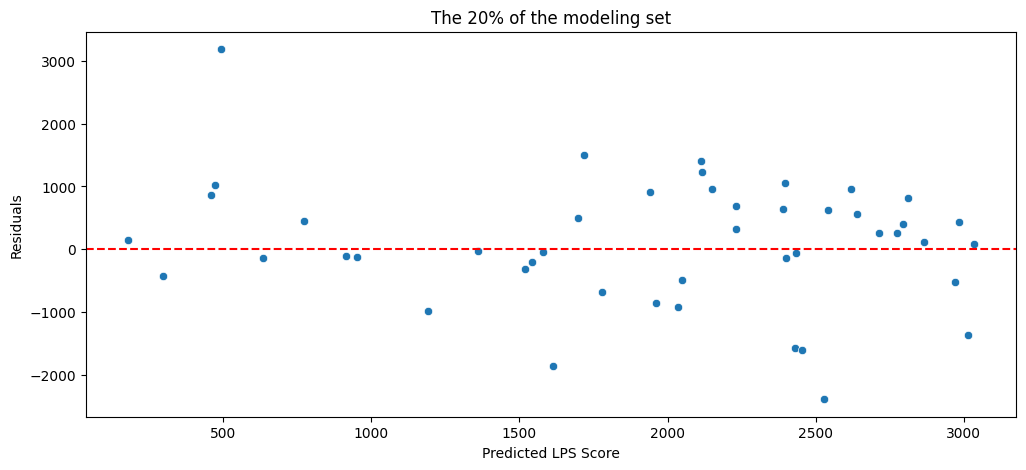

In [69]:
# two plots side by side
plt.figure(figsize=(12, 5))


p = sns.scatterplot(x=y_pred_test, y=y_test - y_pred_test)
p.set(xlabel="Predicted LPS Score", ylabel="Residuals", title="The 20% of the modeling set")
plt.axhline(0, color="red", linestyle="--")

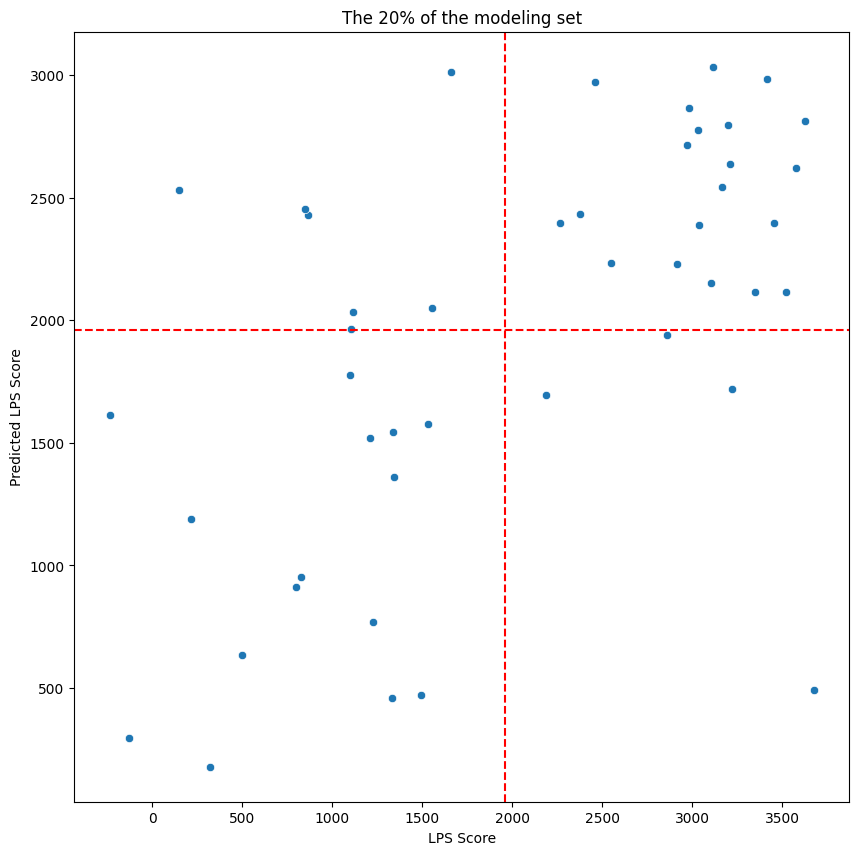

In [70]:
# two plots side by side
plt.figure(figsize=(10, 10))


p = sns.scatterplot(x=y_test, y= y_pred_test)
p.set(xlabel="LPS Score", ylabel="Predicted LPS Score", title="The 20% of the modeling set")
plt.axhline(1960, color="red", linestyle="--")
plt.axvline(1960, color="red", linestyle="--")

In [71]:
y_test_class = (y_test >= gcb_threshold).astype(int)
y_pred_test_class = (y_pred_test >= gcb_threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test_class, y_pred_test_class)
tn, fp, fn, tp = cm.ravel()

precision = precision_score(y_test_class, y_pred_test_class)
recall = recall_score(y_test_class, y_pred_test_class)
f1 = f1_score(y_test_class, y_pred_test_class)

# ROC and AUC
# For ROC, we should use the raw prediction values (or probabilities in classification models).
# Here, using continuous predictions from ElasticNet:
fpr, tpr, _ = roc_curve(y_test_class, y_pred_test)
roc_auc = auc(fpr, tpr)

print(f"\n--- Classification Metrics (Threshold = {gcb_threshold}) ---")
print("Confusion Matrix:")
print(cm)
print("Precision:", precision)
print("Recall:   ", recall)
print("F1 Score: ", f1)
print("AUC:      ", roc_auc)


--- Classification Metrics (Threshold = 1960) ---
Confusion Matrix:
[[15  7]
 [ 4 20]]
Precision: 0.7407407407407407
Recall:    0.8333333333333334
F1 Score:  0.7843137254901961
AUC:       0.8371212121212122


## Build a Final model and Validate

Using the parameters of of the best_model, create a final model and check the validation set

In [72]:
grid_search.best_params_

{'model__alpha': 10.0, 'model__l1_ratio': 0.99}

In [80]:
final_model = ElasticNet(
    alpha=grid_search.best_params_["model__alpha"],
    l1_ratio=grid_search.best_params_["model__l1_ratio"],
    max_iter=1000000,
)

final_model.fit(X, y)
y_pred_val = final_model.predict(X_val)

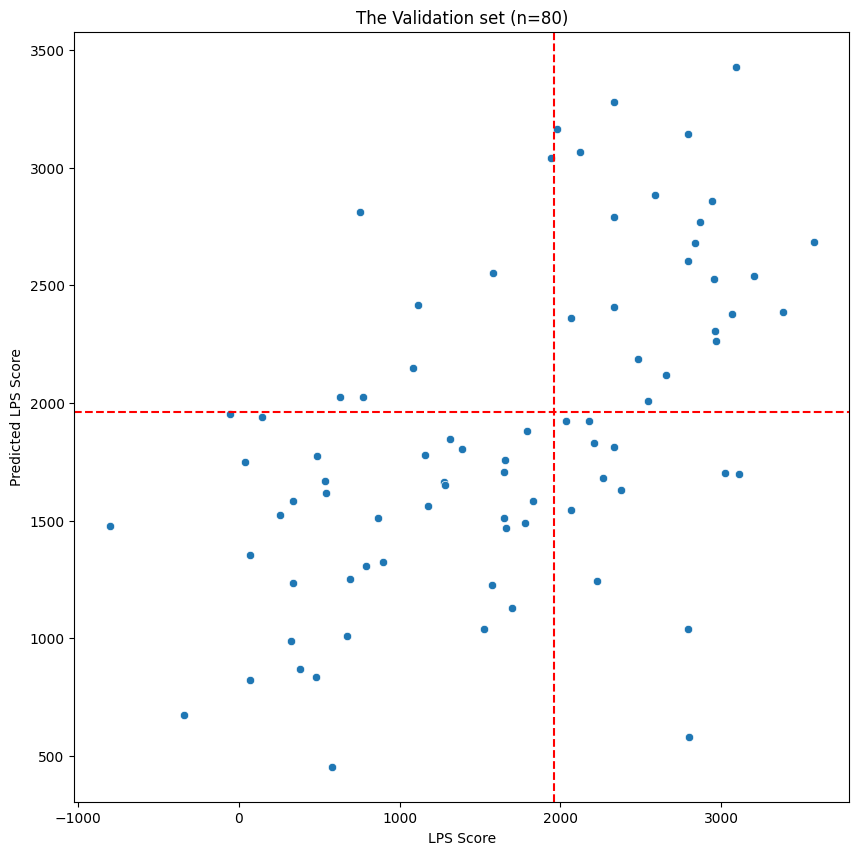

In [81]:
plt.figure(figsize=(10, 10))


p = sns.scatterplot(x=y_val, y= y_pred_val)
p.set(xlabel="LPS Score", ylabel="Predicted LPS Score", title="The Validation set (n=80)")
plt.axhline(1960, color="red", linestyle="--")
plt.axvline(1960, color="red", linestyle="--")

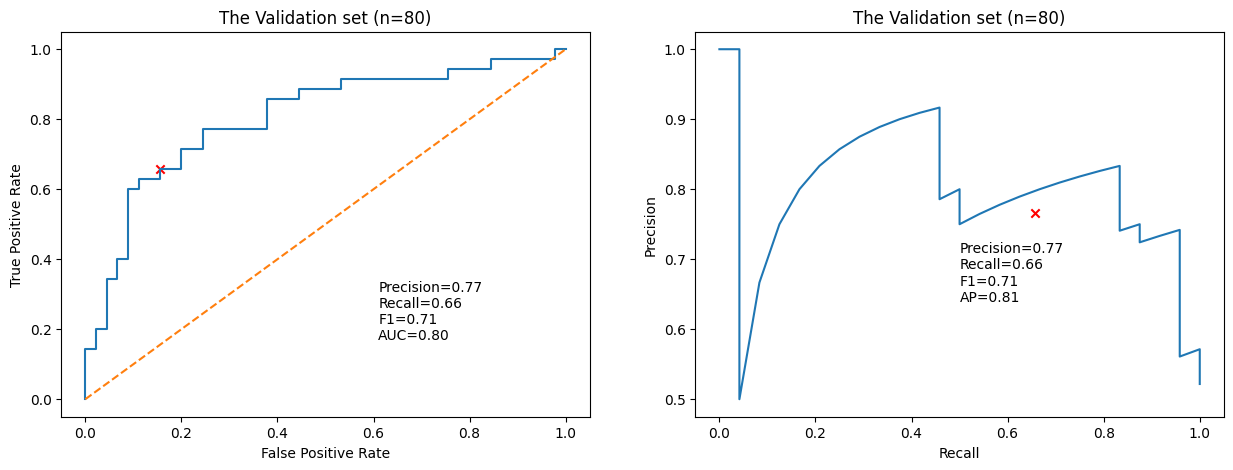

In [ ]:

y_val_class = (y_val >= gcb_threshold).astype(int)
y_pred_val_class = (y_pred_val >= gcb_threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y_val_class, y_pred_val_class)
tn, fp, fn, tp = cm.ravel()

precision = precision_score(y_val_class, y_pred_val_class)
recall = recall_score(y_val_class, y_pred_val_class)
f1 = f1_score(y_val_class, y_pred_val_class)

# ROC and AUC
# For ROC, we should use the raw prediction values (or probabilities in classification models).
# Here, using continuous predictions from ElasticNet:
fpr, tpr, _ = roc_curve(y_val_class, y_pred_val)
roc_auc = auc(fpr, tpr)


# Precision-Recall curve
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test_class, y_pred_test)
pr_auc = average_precision_score(y_test_class, y_pred_test)

# Plot 1: ROC
fig1, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
ax[0].plot([0, 1], [0, 1], linestyle='--')
ax[0].scatter(fp / (fp + tn), tp / (tp + fn), color="red", marker="x")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("The Validation set (n=80)")
ax[0].text(
    0.6, 0.2,
    f"Precision={precision:.2f}\nRecall={recall:.2f}\nF1={f1:.2f}\nAUC={roc_auc:.2f}",
    transform=ax[0].transAxes
)

# Plot 2: Precision-Recall
ax[1].plot(recall_vals, precision_vals, label=f"AP= {pr_auc:.2f}")
ax[1].scatter(tp / (tp + fn), tp/(tp+fp), color="red", marker="x")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("The Validation set (n=80)")
ax[1].text(
    0.5, 0.3,
    f"Precision={precision:.2f}\nRecall={recall:.2f}\nF1={f1:.2f}\nAP={pr_auc:.2f}",
    transform=ax[1].transAxes
)
plt.show()


In [85]:
print(cm)

[[38  7]
 [12 23]]
